Running test case 0 with input '0.5'...
outs =>  [0.8124999999999999, 0.18749999999999997]
Correct!
Running test case 1 with input '0.577350269'...
outs =>  [0.7777777778507647, 0.2222222221492352]
Correct!


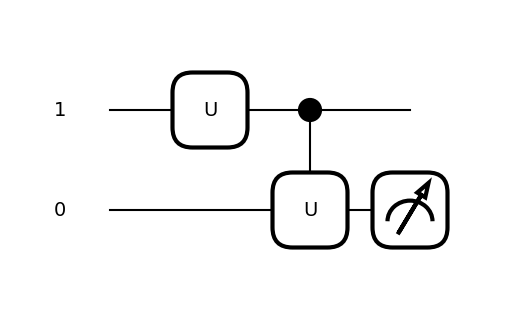

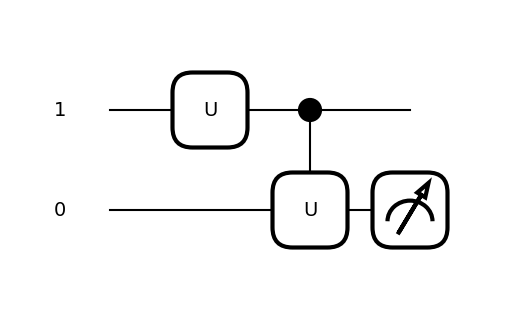

In [67]:
import json
import pennylane as qml
import pennylane.numpy as np

def beam_splitter(r):
    t = np.sqrt(1-r**2)

    return np.array([[t,r],
                     [r,-t]])

def beam_splitter_rt(r):
    t = np.sqrt(1-r**2)

    return np.array([[r,t], 
                   [t, -r]])


dev = qml.device('default.qubit')

@qml.qnode(dev)
def mz_interferometer(r):
    def beam_splitter_rt(r):
        t = np.sqrt(1-r**2)

        return np.array([[r,t], 
                    [t, -r]])    
    qml.QubitUnitary(beam_splitter(r), wires=[1])
    qml.ctrl(qml.QubitUnitary, control=[1], control_values=[1])(beam_splitter_rt(r), wires=[0])
    return qml.probs([0])

def run(test_case_input: str) -> str:
    ins = json.loads(test_case_input)
    outs = mz_interferometer(ins).tolist()
    print ("outs => ", outs)
    qml.draw_mpl(mz_interferometer)(ins)
    return str(outs)

def check(solution_output: str, expected_output: str) -> None:
    solution_output = json.loads(solution_output)
    expected_output = json.loads(expected_output)
    assert np.allclose(solution_output,expected_output), "Not the correct probabilities"

# These are the public test cases
test_cases = [
    ('0.5', '[0.8125, 0.1875]'),
    ('0.577350269', '[0.777778, 0.222222]')
]

# This will run the public test cases locally
for i, (input_, expected_output) in enumerate(test_cases):
    print(f"Running test case {i} with input '{input_}'...")

    try:
        output = run(input_)

    except Exception as exc:
        print(f"Runtime Error. {exc}")

    else:
        if message := check(output, expected_output):
            print(f"Wrong Answer. Have: '{output}'. Want: '{expected_output}'.")

        else:
            print("Correct!")

In [43]:

dev = qml.device("default.qubit", wires=["player1", "player2", "goalie"])

# Put any extra functions you want here

def state_prep(player_coeffs, goalie_coeffs):
    alpha, beta, kappa = player_coeffs
    gamma, delta = 1,0
    coeffs = [kappa*gamma, kappa*delta, alpha*gamma, alpha*delta, beta*gamma, beta*delta, kappa*gamma, kappa*delta]
    qml.AmplitudeEmbedding(coeffs, wires=['player1', 'player2', 'goalie'])
    
@qml.qnode(dev)
def save_percentage(player_coeffs, goalie_coeffs, x, y, z):
    state_prep(player_coeffs, goalie_coeffs)

    pm1 = qml.measure('player1')
    pm2 = qml.measure('player2')

    gamma, delta = np.array(goalie_coeffs)

    def player_10():
        qml.RY(np.arccos(np.sqrt(x)*gamma)*2, wires='goalie')

    def player_01():
        qml.RY(np.arccos(np.sqrt(y)*gamma)*2, wires='goalie')

    def player_00_11():
        qml.RY(np.arcsin(np.sqrt(z)*delta)*2, wires='goalie')
        
    qml.cond(pm1 > pm2, player_10, None)()
    qml.cond(pm1 < pm2, player_01, None)()
    qml.cond(pm1 == pm2, player_00_11, None)()

    return qml.probs(wires="goalie")
# These functions are responsible for testing the solution.
def run(test_case_input: str) -> str:
    ins = json.loads(test_case_input)
    player_coeffs, goalie_coeffs, x, y, z = ins
    output = save_percentage(player_coeffs, goalie_coeffs, x, y, z).tolist()
    return str(output)

def check(solution_output: str, expected_output: str) -> None:
    solution_output = json.loads(solution_output)
    sp = solution_output
    _sp = json.loads(expected_output)
    print (sp, _sp)
    ops = save_percentage.tape._ops
    num_ops = len(ops)
    num_cond = [op.name for op in ops].count('Conditional')
    names = [op.name for op in ops]
    state_prep_check = ('StatePrep' or 'MottonenStatePreparation' or 'AmplitudeEmbedding') in names

    assert np.allclose(sp, _sp, rtol=1e-4), "Your calculated save percentage is incorrect."
    assert num_ops < 8, "You used more than 7 operations in your save_percentage function."
    assert num_ops > 2, "You definitely need more than 2 operations..."
    # assert state_prep_check, "You can use StatePrep, MottonenStatePreparation, or AmplitudeEmbedding to prepare states."
    assert num_cond == 3, "You haven't used exactly 3 qml.cond operators."

# These are the public test cases
test_cases = [
    ('[[0.74199663, 0.17932039, 0.45677413], [0.28034464, 0.95989941], 0.999, 0.99, 0.98]', '[0.08584767923415959, 0.9141523336414634]'),
    ('[[0.09737041, 0.40230525, 0.64368839], [0.00111111, 0.99999938], 0.9, 0.95, 0.92]', '[0.06629469110239884, 0.9337053066603161]')
]

# This will run the public test cases locally
for i, (input_, expected_output) in enumerate(test_cases):
    print(f"Running test case {i} with input '{input_}'...")

    try:
        output = run(input_)

    except Exception as exc:
        print(f"Runtime Error. {exc}")

    else:
        if message := check(output, expected_output):
            print(f"Wrong Answer. Have: '{output}'. Want: '{expected_output}'.")

        else:
            print("Correct!")

Running test case 0 with input '[[0.74199663, 0.17932039, 0.45677413], [0.28034464, 0.95989941], 0.999, 0.99, 0.98]'...
[0.08584768105869747, 0.9141523318169253] [0.08584767923415959, 0.9141523336414634]
Correct!
Running test case 1 with input '[[0.09737041, 0.40230525, 0.64368839], [0.00111111, 0.99999938], 0.9, 0.95, 0.92]'...
[0.06629469524528334, 0.9337053025174313] [0.06629469110239884, 0.9337053066603161]
Correct!


In [59]:
np.sqrt(1-(0.5**2))**2

0.7499999999999999